Source: This example comes from the torch adaptation of Charles Ollion [/github/charlesollion].

In [148]:
import torch
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import time
import matplotlib.pyplot as plt

Data Acquisition

In [149]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

#DATA LOADING
df = pd.read_csv("AAPL_2006-01-01_to_2018-01-01.csv")
df = df.drop(columns=["Name"])

df["Date"] = pd.to_datetime(df["Date"])
df = df.sort_values("Date").set_index("Date")

print(df.head())

X = df.values

             Open   High    Low  Close     Volume
Date                                             
2006-01-03  10.34  10.68  10.32  10.68  201853036
2006-01-04  10.73  10.85  10.64  10.71  155225609
2006-01-05  10.69  10.70  10.54  10.63  112396081
2006-01-06  10.75  10.96  10.65  10.90  176139334
2006-01-09  10.96  11.03  10.82  10.86  168861224


Function for splitting the dataset into sequences of observations of length history size.

In [150]:
def sequencing(dataset, start_index=0, end_index=None, history_size=13, step=1):
    data = []
    start_index = start_index + history_size
    if end_index is None:
        end_index = len(dataset)
    for i in range(start_index, end_index):
        indices = range(i - history_size, i, step)
        data.append(dataset[indices])
    return np.array(data)


Function for splitting the dataset into training and validation, and data normalization.

In [151]:
def partition(data, pTrain=0.7, pVal=0.15, history_size=13, step=1):
    # sequence first
    sequenced = sequencing(
        data,
        history_size=history_size,
        step=step
    )  # (N, 13, F)

    N = sequenced.shape[0]
    n_train = int(pTrain * N)
    n_val   = int((pTrain + pVal) * N)

    dataTrain = sequenced[:n_train]
    dataVal   = sequenced[n_train:n_val]
    dataTest  = sequenced[n_val:]

    # normalize using TRAIN ONLY
    train_flat = dataTrain.reshape(-1, dataTrain.shape[-1])
    data_mean = train_flat.mean(axis=0)
    data_std  = train_flat.std(axis=0)
    data_std  = np.where(data_std == 0, 1.0, data_std)

    dataTrain = (dataTrain - data_mean) / data_std
    dataVal   = (dataVal   - data_mean) / data_std
    dataTest  = (dataTest  - data_mean) / data_std

    return dataTrain, dataVal, dataTest, data_mean, data_std


Create input-putput pairs.

In [152]:
def split(chunk):
    inputs = torch.tensor(chunk[:, :-1, :], dtype=torch.float32, device=device)
    targets = torch.tensor(chunk[:, 1:, :], dtype=torch.float32, device=device)

    return inputs, targets

device = "mps" if torch.backends.mps.is_available() else torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

Loaders

In [153]:
def createLoaders(dataTrain, dataVal, dataTest=None, batchSize=32, responseVariables=list(range(5))):
    XTrain, YTrain = split(dataTrain)
    XVal, YVal = split(dataVal)

    YTrain = YTrain[:,:,responseVariables]
    YVal = YVal[:,:,responseVariables]

    trainDS = torch.utils.data.TensorDataset(XTrain, YTrain)
    valDS = torch.utils.data.TensorDataset(XVal, YVal)

    trainLoader = torch.utils.data.DataLoader(trainDS, batch_size=batchSize)
    valLoader = torch.utils.data.DataLoader(valDS, batch_size=batchSize)

    if dataTest is not None:
        XTest, YTest = split(dataTest)
        YTest = YTest[:,:,responseVariables]
        testDS = torch.utils.data.TensorDataset(XTest, YTest)
        testLoader = torch.utils.data.DataLoader(testDS, batch_size=batchSize)
    else:
        testLoader = None

    return trainLoader, valLoader, testLoader


trainData, valData, testData, data_mean, data_std = partition(X)
trainDataset, valDataset, testDataset = createLoaders(trainData, valData, testData)

Transformer NN implementation

In [154]:
import torch.nn as nn
import math

class MultiHeadAttention(nn.Module):
    def __init__(self, D, H):
        super(MultiHeadAttention, self).__init__()
        self.H = H # number of heads
        self.D = D # dimension
        
        self.wq = nn.Linear(D, D*H)
        self.wk = nn.Linear(D, D*H)
        self.wv = nn.Linear(D, D*H)

        self.dense = nn.Linear(D*H, D)

    def concat_heads(self, x):
        '''(B, H, S, D) => (B, S, D*H)'''
        B, H, S, D = x.shape
        x = x.permute((0, 2, 1, 3)).contiguous()  # (B, S, H, D)
        x = x.reshape((B, S, H*D))   # (B, S, D*H)
        return x

    def split_heads(self, x):
        '''(B, S, D*H) => (B, H, S, D)'''
        B, S, D_H = x.shape
        x = x.reshape(B, S, self.H, self.D)    # (B, S, H, D)
        x = x.permute((0, 2, 1, 3))  # (B, H, S, D)
        return x

    def forward(self, x, mask):

        q = self.wq(x)  # (B, S, D*H)
        k = self.wk(x)  # (B, S, D*H)
        v = self.wv(x)  # (B, S, D*H)

        q = self.split_heads(q)  # (B, H, S, D)
        k = self.split_heads(k)  # (B, H, S, D)
        v = self.split_heads(v)  # (B, H, S, D)

        attention_scores = torch.matmul(q, k.transpose(-1, -2)) #(B,H,S,S)
        attention_scores = attention_scores / math.sqrt(self.D)

        # add the mask to the scaled tensor.
        if mask is not None:
            attention_scores += (mask * -1e9)
        
        attention_weights = nn.Softmax(dim=-1)(attention_scores)
        scaled_attention = torch.matmul(attention_weights, v)  # (B, H, S, D)
        concat_attention = self.concat_heads(scaled_attention) # (B, S, D*H)
        output = self.dense(concat_attention)  # (B, S, D)

        return output, attention_weights

In [155]:
B, S, H, D = 9, 11, 5, 8
mha = MultiHeadAttention(D, H)
out, att = mha.forward(torch.zeros(B, S, D), mask=None)
out.shape, att.shape

(torch.Size([9, 11, 8]), torch.Size([9, 5, 11, 11]))

In [156]:
# Positional encodings
def get_angles(pos, i, D):
    angle_rates = 1 / np.power(10000, (2 * (i // 2)) / np.float32(D))
    return pos * angle_rates


def positional_encoding(D, position=2000, dim=3, device=device):
    angle_rads = get_angles(
        np.arange(position)[:, np.newaxis].astype(np.float32),
        np.arange(D)[np.newaxis, :].astype(np.float32),
        D
    )

    angle_rads[:, 0::2] = np.sin(angle_rads[:, 0::2])
    angle_rads[:, 1::2] = np.cos(angle_rads[:, 1::2])

    if dim == 3:
        pos_encoding = angle_rads[np.newaxis, ...]
    elif dim == 4:
        pos_encoding = angle_rads[np.newaxis, np.newaxis, ...]

    # Convert to float32 Tensor
    return torch.tensor(pos_encoding, dtype=torch.float32, device=device)


# function that implement the look_ahead mask for masking future time steps. 
def create_look_ahead_mask(size, device=device):
    mask = torch.ones((size, size), device=device)
    mask = torch.triu(mask, diagonal=1)
    return mask  # (size, size)

create_look_ahead_mask(6)

class TransformerLayer(nn.Module):
    def __init__(self, D, H, hidden_mlp_dim, dropout_rate):
        super(TransformerLayer, self).__init__()
        self.dropout_rate = dropout_rate
        self.mlp_hidden = nn.Linear(D, hidden_mlp_dim)
        self.mlp_out = nn.Linear(hidden_mlp_dim, D)
        self.layernorm1 = nn.LayerNorm(D, eps=1e-9)
        self.layernorm2 = nn.LayerNorm(D, eps=1e-9)
        self.dropout1 = nn.Dropout(dropout_rate)
        self.dropout2 = nn.Dropout(dropout_rate)

        self.mha = MultiHeadAttention(D, H)


    def forward(self, x, look_ahead_mask):
        
        attn, attn_weights = self.mha(x, look_ahead_mask)  # (B, S, D)
        attn = self.dropout1(attn) # (B,S,D)
        attn = self.layernorm1(attn + x) # (B,S,D)

        mlp_act = torch.relu(self.mlp_hidden(attn))
        mlp_act = self.mlp_out(mlp_act)
        mlp_act = self.dropout2(mlp_act)
        
        output = self.layernorm2(mlp_act + attn)  # (B, S, D)

        return output, attn_weights

In [157]:
dl = TransformerLayer(16, 3, 32, 0.1)
out, attn = dl(x=torch.zeros(5, 7, 16), look_ahead_mask=None)
out.shape, attn.shape

(torch.Size([5, 7, 16]), torch.Size([5, 3, 7, 7]))

In [158]:
class Transformer(nn.Module):
    '''Transformer Decoder Implementating several Decoder Layers.
    '''
    def __init__(self, num_layers, D, H, hidden_mlp_dim, inp_features, out_features, dropout_rate):
        super(Transformer, self).__init__()
        #self.sqrt_D = torch.tensor(math.sqrt(D))
        self.register_buffer("sqrt_D", torch.tensor(math.sqrt(D), dtype=torch.float32))

        self.num_layers = num_layers
        self.input_projection = nn.Linear(inp_features, D) # multivariate input
        self.output_projection = nn.Linear(D, out_features) # multivariate output
        self.pos_encoding = positional_encoding(D)
        self.dec_layers = nn.ModuleList([TransformerLayer(D, H, hidden_mlp_dim, 
                                        dropout_rate=dropout_rate
                                       ) for _ in range(num_layers)])
        self.dropout = nn.Dropout(dropout_rate)

    def forward(self, x, mask):
        B, S, D = x.shape
        attention_weights = {}
        x = self.input_projection(x)
        x *= self.sqrt_D
        
        x += self.pos_encoding[:, :S, :]

        x = self.dropout(x)

        for i in range(self.num_layers):
            x, block = self.dec_layers[i](x=x,
                                          look_ahead_mask=mask)
            attention_weights['decoder_layer{}'.format(i + 1)] = block
        
        x = self.output_projection(x)
        
        return x, attention_weights # (B,S,S)

In [159]:
# Test Forward pass on the Transformer: 
transformer = Transformer(num_layers=1, D=32, H=1, hidden_mlp_dim=32,
                                       inp_features=5, out_features=5, dropout_rate=0.1)
transformer.to(device)
(inputs, targets) = next(iter(trainDataset))
                         
S = inputs.shape[1]
mask = create_look_ahead_mask(S)
out, attn = transformer (x=inputs, mask=mask)
out.shape, attn["decoder_layer1"].shape

(torch.Size([32, 12, 5]), torch.Size([32, 1, 12, 12]))

Training the Transformer

In [160]:
param_sizes = [p.numel() for p in transformer.parameters()]
print(f"number of weight/biases matrices: {len(param_sizes)} "
      f"for a total of {np.sum(param_sizes)} parameters ")

number of weight/biases matrices: 20 for a total of 6821 parameters 


In [161]:
transformer = Transformer(num_layers=1, D=32, H=4, hidden_mlp_dim=32,
                          inp_features=5, out_features=5, dropout_rate=0.1).to(device)
optimizer = torch.optim.RMSprop(transformer.parameters(), 
                                lr=0.00005)

In [162]:
from tqdm import tqdm

n_epochs = 20
losses, val_losses = [], []

for e in range(n_epochs):
    # TRAINING
    transformer.train()
    sum_train_loss = 0.0
    for x, y in trainDataset:

        # Create proper look-ahead mask
        S = x.shape[1]
        mask = create_look_ahead_mask(S).unsqueeze(0).unsqueeze(0).to(device)

        # Forward pass
        out, _ = transformer(x, mask)

        # Loss
        loss = torch.nn.MSELoss()(out, y)
        sum_train_loss += loss.item()

        # Backprop
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    losses.append(sum_train_loss / len(trainDataset))

    # VALIDATION
    transformer.eval()
    sum_val_loss = 0.0
    with torch.no_grad():
        for x, y in valDataset:

            S = x.shape[1]
            mask = create_look_ahead_mask(S).unsqueeze(0).unsqueeze(0).to(device)

            out, _ = transformer(x, mask)
            loss = torch.nn.MSELoss()(out, y)
            sum_val_loss += loss.item()

    val_losses.append(sum_val_loss / len(valDataset))

    print(f"Epoch {e+1}/{n_epochs} | Train Loss: {losses[-1]:.6f} | Val Loss: {val_losses[-1]:.6f}")


Epoch 1/20 | Train Loss: 0.713596 | Val Loss: 3.383258
Epoch 2/20 | Train Loss: 0.408418 | Val Loss: 2.728248
Epoch 3/20 | Train Loss: 0.309587 | Val Loss: 2.363696
Epoch 4/20 | Train Loss: 0.259222 | Val Loss: 2.134845
Epoch 5/20 | Train Loss: 0.230984 | Val Loss: 1.976197
Epoch 6/20 | Train Loss: 0.210860 | Val Loss: 1.855187
Epoch 7/20 | Train Loss: 0.195063 | Val Loss: 1.759042
Epoch 8/20 | Train Loss: 0.183130 | Val Loss: 1.675749
Epoch 9/20 | Train Loss: 0.173206 | Val Loss: 1.596174
Epoch 10/20 | Train Loss: 0.165293 | Val Loss: 1.527188
Epoch 11/20 | Train Loss: 0.157776 | Val Loss: 1.460361
Epoch 12/20 | Train Loss: 0.151667 | Val Loss: 1.399203
Epoch 13/20 | Train Loss: 0.145821 | Val Loss: 1.342634
Epoch 14/20 | Train Loss: 0.141835 | Val Loss: 1.288587
Epoch 15/20 | Train Loss: 0.137812 | Val Loss: 1.239813
Epoch 16/20 | Train Loss: 0.134551 | Val Loss: 1.192830
Epoch 17/20 | Train Loss: 0.131849 | Val Loss: 1.154458
Epoch 18/20 | Train Loss: 0.128576 | Val Loss: 1.117950
E

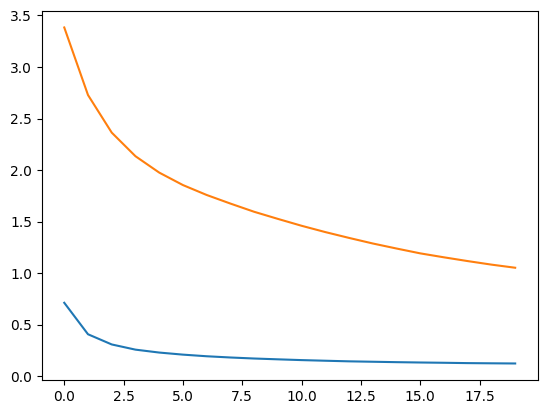

In [163]:
plt.plot(losses)
plt.plot(val_losses)

In [164]:
# Evaluate on test data
transformer.eval()

all_preds = []
all_targets = []

with torch.no_grad():
    for x, y in testDataset:
        S = x.shape[1]
        mask = create_look_ahead_mask(S).unsqueeze(0).unsqueeze(0).to(device)
        preds, _ = transformer(x, mask)

        all_preds.append(preds.cpu().numpy())
        all_targets.append(y.cpu().numpy())

# Convert to arrays
all_preds = np.concatenate(all_preds, axis=0)
all_targets = np.concatenate(all_targets, axis=0)

print(all_preds.shape, all_targets.shape)

(451, 12, 5) (451, 12, 5)


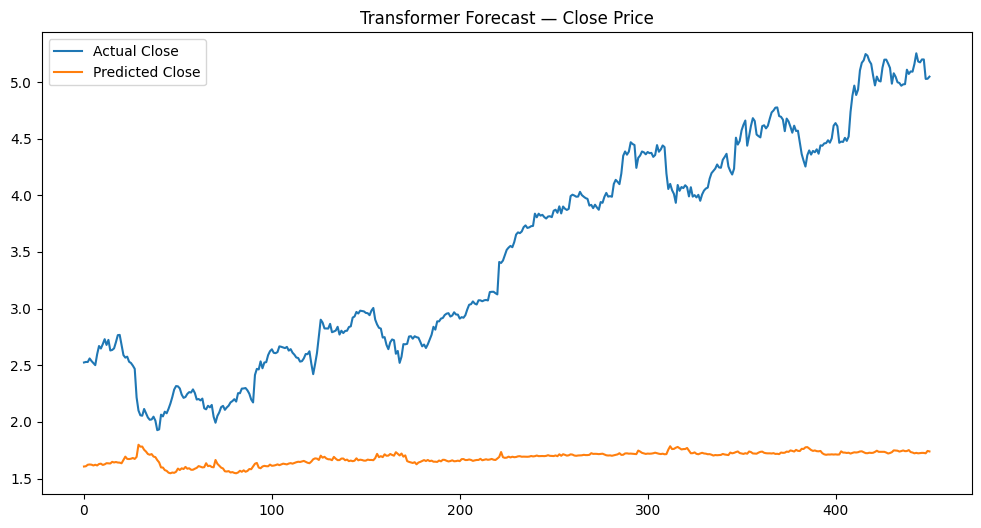

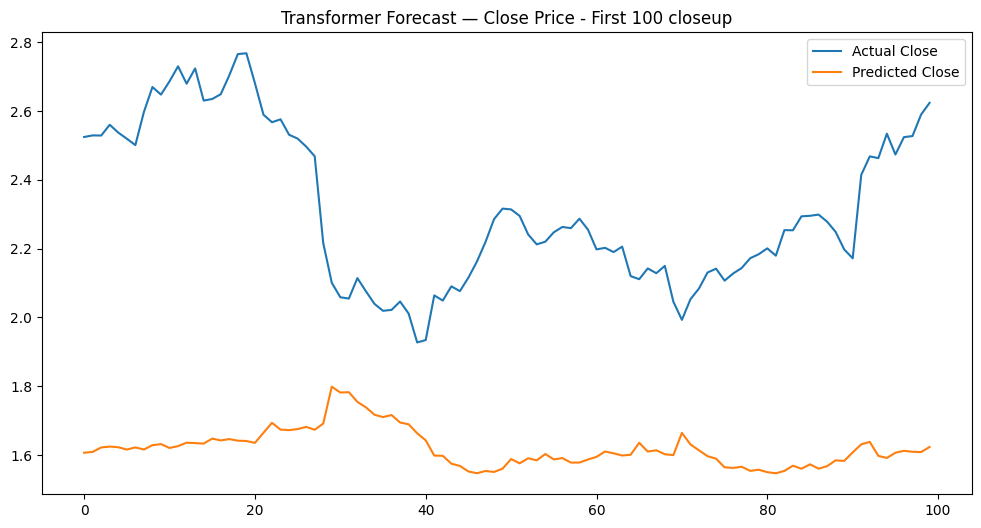

In [165]:
import matplotlib.pyplot as plt

feature_idx = 3  # Close price

plt.figure(figsize=(12,6))
plt.plot(all_targets[:, -1, feature_idx], label="Actual Close")
plt.plot(all_preds[:, -1, feature_idx], label="Predicted Close")
plt.title("Transformer Forecast — Close Price")
plt.legend()
plt.show()

import matplotlib.pyplot as plt

plt.figure(figsize=(12,6))
plt.plot(all_targets[:100, -1, feature_idx], label="Actual Close")
plt.plot(all_preds[:100, -1, feature_idx], label="Predicted Close")
plt.title("Transformer Forecast — Close Price - First 100 closeup")
plt.legend()
plt.show()

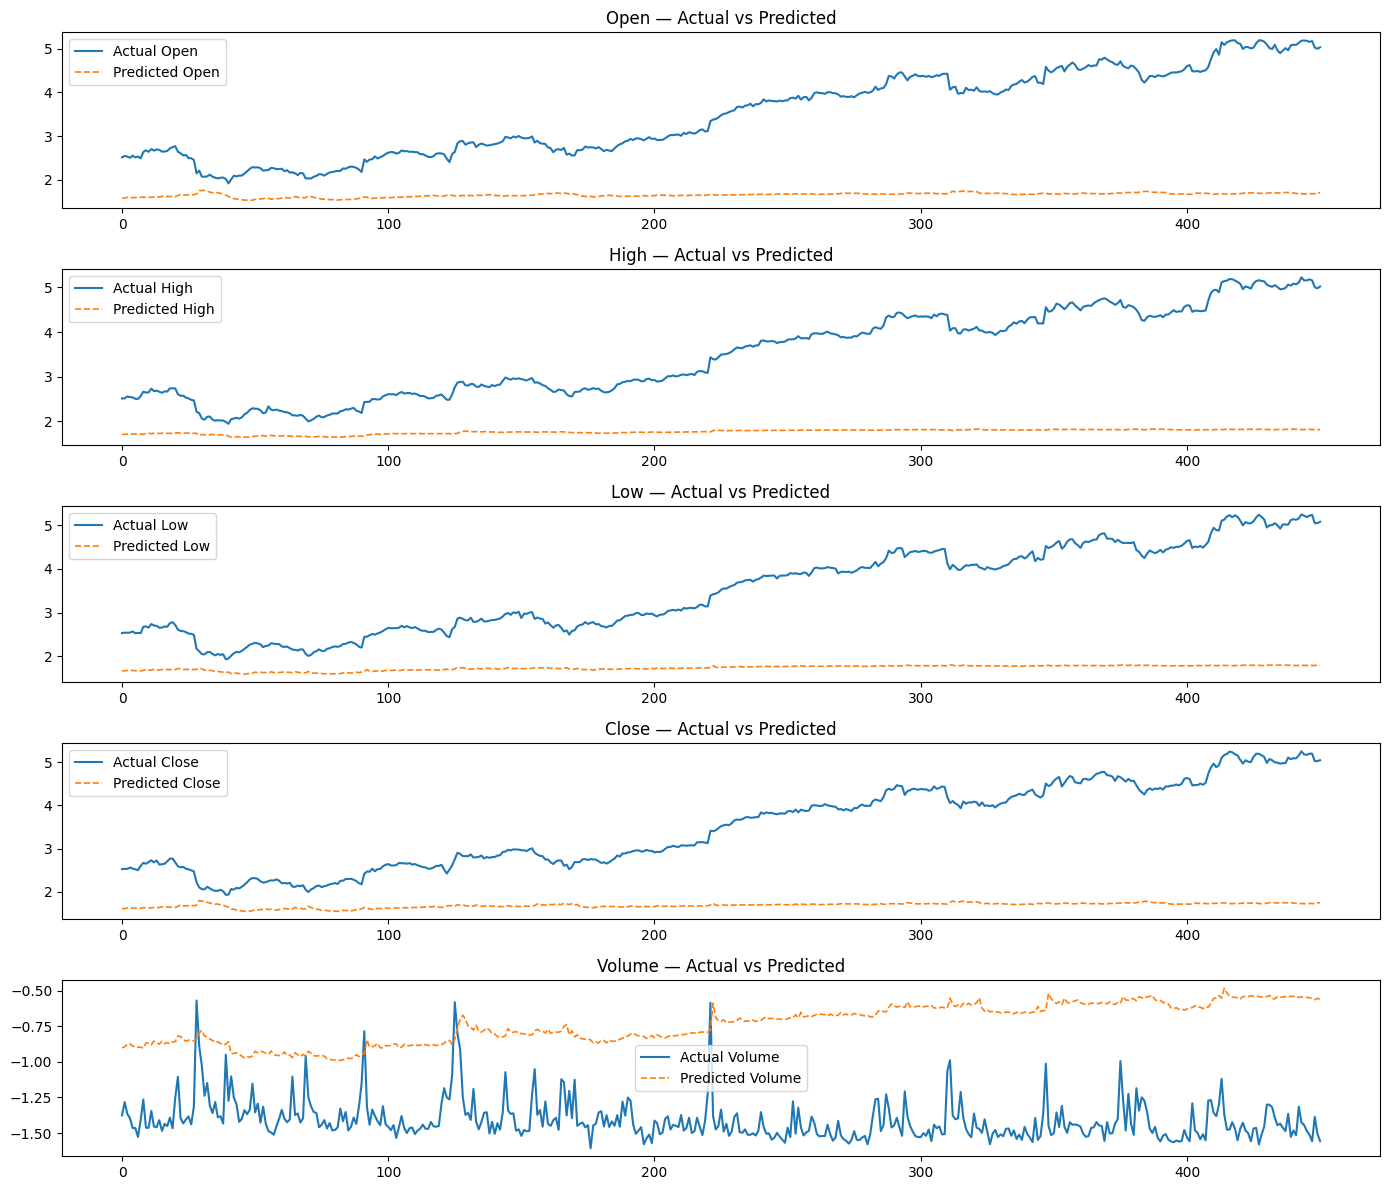

In [166]:
import matplotlib.pyplot as plt

feature_names = ["Open", "High", "Low", "Close", "Volume"]

plt.figure(figsize=(14, 12))

for i, name in enumerate(feature_names):
    plt.subplot(5, 1, i+1)
    plt.plot(all_targets[:, -1, i], label=f"Actual {name}", linewidth=1.5)
    plt.plot(all_preds[:, -1, i], label=f"Predicted {name}", linestyle="--", linewidth=1.2)
    plt.title(f"{name} — Actual vs Predicted")
    plt.legend()
    plt.tight_layout()

plt.show()


In [167]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

def print_eval(feature_names, all_targets, all_preds, data_mean, data_std):
    for i, name in enumerate(feature_names):
        actual = all_targets[:, -1, i] * data_std[i] + data_mean[i]
        pred = all_preds[:, -1, i] * data_std[i] + data_mean[i]
        mae = mean_absolute_error(actual, pred)
        rmse = np.sqrt(mean_squared_error(actual, pred))

        print(f"{name}: MAE={mae:.4f}, RMSE={rmse:.4f}")

print_eval(feature_names, all_targets, all_preds, data_mean, data_std)

Open: MAE=47.4886, RMSE=53.3245
High: MAE=44.5431, RMSE=50.5592
Low: MAE=45.3606, RMSE=51.1136
Close: MAE=46.6943, RMSE=52.4999
Volume: MAE=66584412.0000, RMSE=69567621.5975


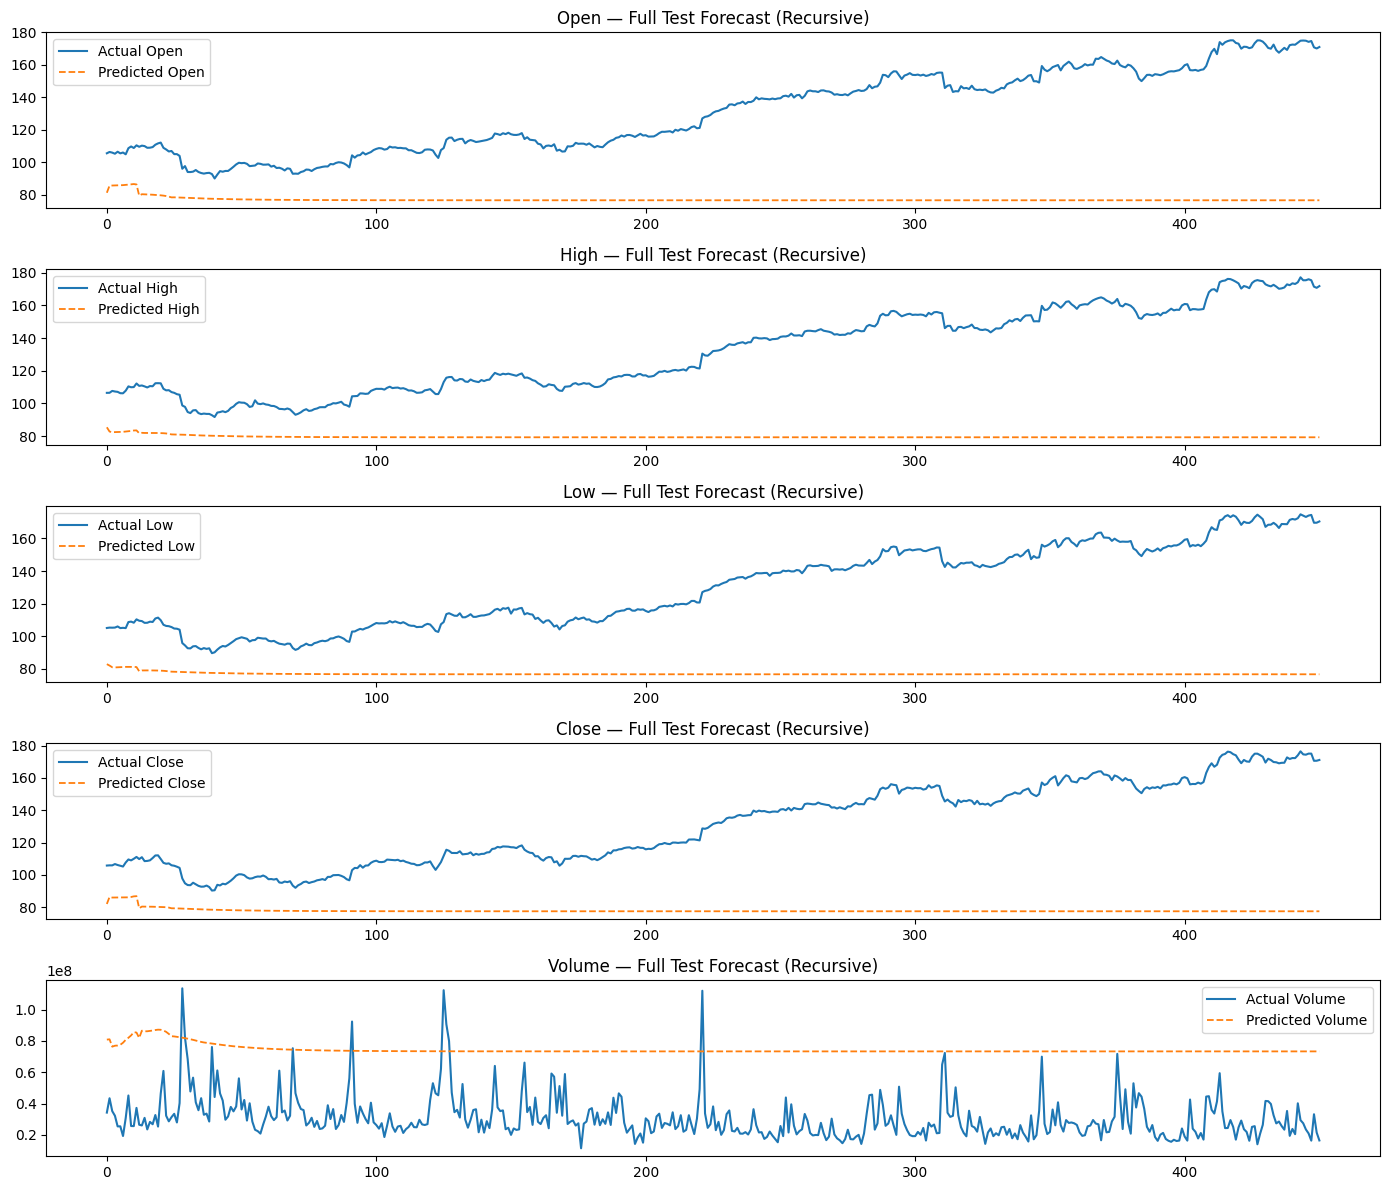

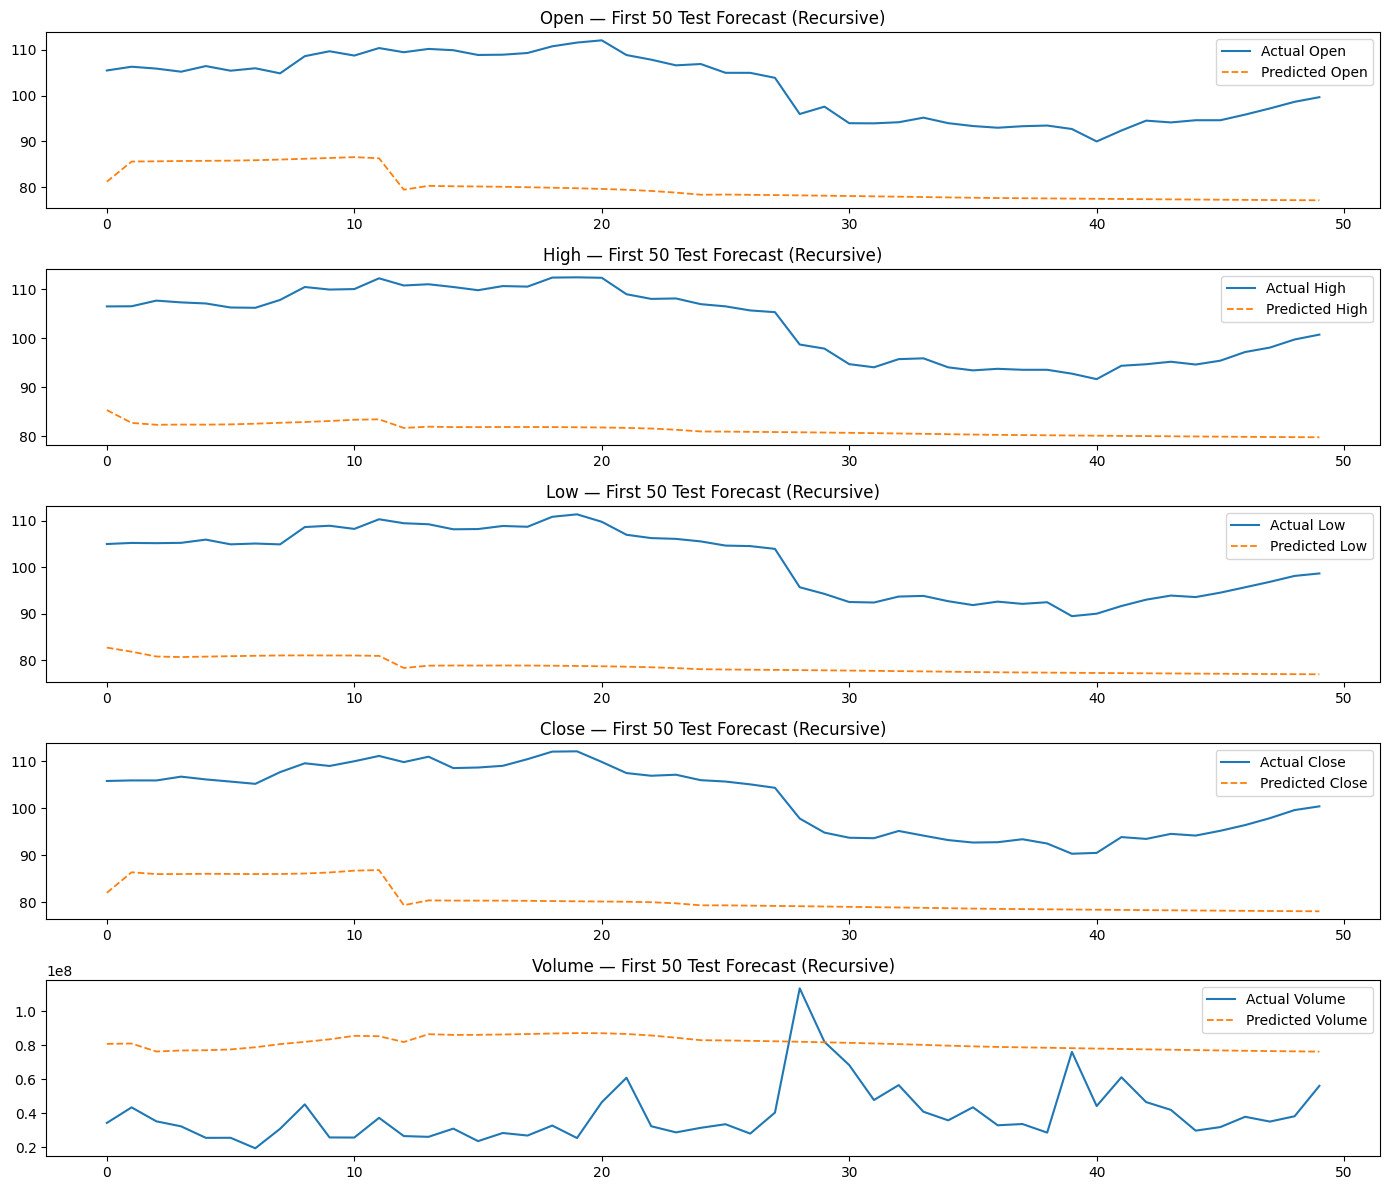

In [168]:
def eval_rollout(transformer, testDataset, data_mean, data_std):
    transformer.eval()

    x_test, y_test = next(iter(testDataset))

    # Sequence length and feature count
    S = x_test.shape[1]
    F = x_test.shape[2]

    seed_input = x_test[0:1].clone().to(device)   # shape: (1, S, F)

    real_test = []

    for bx, by in testDataset:
        real_test.append(by.cpu().numpy())

    real_test = np.concatenate(real_test, axis=0)   # shape: (N_test, S, F)

    N_test = real_test.shape[0]   # how many predictions you need

    preds = []

    input_seq = seed_input.clone()  # rolling window

    with torch.no_grad():
        for _ in range(N_test):

            S_current = input_seq.shape[1]
            mask = create_look_ahead_mask(S_current).unsqueeze(0).unsqueeze(0).to(device)

            output, _ = transformer(input_seq, mask)

            next_step = output[:, -1:, :]             # (1, 1, F)
            preds.append(next_step.detach().cpu().numpy())

            input_seq = torch.cat([input_seq[:, 1:, :], next_step], dim=1)

    preds = np.concatenate(preds, axis=0)        # (N_test, 1, F)
    preds = preds[:, 0, :]                       # (N_test, F)

    real = real_test[:, -1, :]                   # (N_test, F)

    feature_names = ["Open", "High", "Low", "Close", "Volume"]

    plt.figure(figsize=(14,12))

    real_orig = real * data_std + data_mean
    preds_orig = preds * data_std + data_mean

    for i, name in enumerate(feature_names):
        plt.subplot(5, 1, i+1)
        plt.plot(real_orig[:, i], label=f"Actual {name}", linewidth=1.5)
        plt.plot(preds_orig[:, i], "--", label=f"Predicted {name}", linewidth=1.3)
        plt.title(f"{name} — Full Test Forecast (Recursive)")
        plt.legend()
        plt.tight_layout()

    plt.show()

    plt.figure(figsize=(14,12))

    for i, name in enumerate(feature_names):
        plt.subplot(5, 1, i+1)
        plt.plot(real_orig[:50, i], label=f"Actual {name}", linewidth=1.5)
        plt.plot(preds_orig[:50, i], "--", label=f"Predicted {name}", linewidth=1.3)
        plt.title(f"{name} — First 50 Test Forecast (Recursive)")
        plt.legend()
        plt.tight_layout()

    plt.show()


eval_rollout(transformer, testDataset, data_mean, data_std)

In [ ]:
def rmse_per_feature_original(model, testLoader, data_mean, data_std, device):
    model.eval()

    mean_t = torch.tensor(data_mean, dtype=torch.float32, device=device).view(1, 1, -1)
    std_t  = torch.tensor(data_std,  dtype=torch.float32, device=device).view(1, 1, -1)

    S = next(iter(testLoader))[0].shape[1]
    mask = create_look_ahead_mask(S).to(device)

    se_sum = None
    n = 0

    with torch.no_grad():
        for xb, yb in testLoader:
            out_norm, _ = model(xb, mask)

            out_norm = out_norm[:, -1:, :]
            yb = yb[:, -1:, :]

            out = out_norm * std_t + mean_t
            y   = yb       * std_t + mean_t

            se = (out - y) ** 2                    # (B,1,F)
            se_f = se.sum(dim=(0,1))               # (F,)

            se_sum = se_f if se_sum is None else se_sum + se_f
            n += se.shape[0]                       # B (since 1 step)

    mse_f = (se_sum / n).detach().cpu().numpy()
    return np.sqrt(mse_f)


feature_names = ["Open", "High", "Low", "Close", "Volume"]
rmse_f = rmse_per_feature_original(transformer, testDataset, data_mean, data_std, device)
for n, v in zip(feature_names, rmse_f):
    print(f"{n} last-step RMSE (original units): {v:.4f}")


Open last-step RMSE (original units): 53.3245 $
High last-step RMSE (original units): 50.5592 $
Low last-step RMSE (original units): 51.1136 $
Close last-step RMSE (original units): 52.4999 $
Volume last-step RMSE (original units): 69567624.0000 $


# Tuning

In [170]:
import itertools
import numpy as np
import torch

def fit_stats(train_raw):
    mean = train_raw.mean(axis=0)
    std = train_raw.std(axis=0)
    std = np.where(std == 0, 1.0, std)
    return mean, std

def apply_stats(raw, mean, std):
    return (raw - mean) / std

def make_time_folds(T, n_folds=5, test_frac=0.2, val_frac=0.1):
    """
    Returns list of (train_end_raw, val_end_raw) in raw-index space (end exclusive),
    plus test_start_raw.
    """
    test_start = int(T * (1.0 - test_frac))
    trainval_T = test_start
    val_len = max(1, int(trainval_T * val_frac))

    fold_size = trainval_T // (n_folds + 1)
    folds = []
    for i in range(n_folds):
        train_end = fold_size * (i + 1)
        val_end = min(train_end + val_len, trainval_T)
        if val_end > train_end:
            folds.append((train_end, val_end))
    return folds, test_start

def windows_from_raw_with_fold_scaling(raw_X, history_size, train_end_raw, val_end_raw):
    """
    1) fit scaler on raw_X[:train_end_raw]
    2) scale full series with those stats
    3) build sequenced windows on scaled series
    4) select windows whose *end timestep* falls into train or val ranges
    """
    mean, std = fit_stats(raw_X[:train_end_raw])
    X_scaled = apply_stats(raw_X, mean, std)

    seq = sequencing(X_scaled, start_index=0, end_index=None, history_size=history_size, step=1)
    # seq shape: (N_seq, history_size, F)
    # window j ends at raw index: end_raw = j + history_size - 1
    N_seq = seq.shape[0]
    ends = np.arange(N_seq) + history_size - 1

    train_mask = ends < train_end_raw
    val_mask   = (ends >= train_end_raw) & (ends < val_end_raw)

    return seq[train_mask], seq[val_mask], (mean, std)

def createLoaders(dataTrain, dataVal, dataTest=None, batchSize=32, responseVariables=list(range(5)), shuffle_train=True):
    XTrain, YTrain = split(dataTrain)
    XVal, YVal = split(dataVal)

    YTrain = YTrain[:, :, responseVariables]
    YVal   = YVal[:, :, responseVariables]

    trainDS = torch.utils.data.TensorDataset(XTrain, YTrain)
    valDS   = torch.utils.data.TensorDataset(XVal, YVal)

    trainLoader = torch.utils.data.DataLoader(trainDS, batch_size=batchSize, shuffle=shuffle_train)
    valLoader   = torch.utils.data.DataLoader(valDS, batch_size=batchSize, shuffle=False)

    if dataTest is not None:
        XTest, YTest = split(dataTest)
        YTest = YTest[:, :, responseVariables]
        testDS = torch.utils.data.TensorDataset(XTest, YTest)
        testLoader = torch.utils.data.DataLoader(testDS, batch_size=batchSize, shuffle=False)
    else:
        testLoader = None

    return trainLoader, valLoader, testLoader


def train_and_validate_fold(model, train_loader, val_loader, lr=3e-4, epochs=10, weight_decay=0.0):
    model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    criterion = torch.nn.MSELoss()

    S = next(iter(train_loader))[0].shape[1]
    mask = create_look_ahead_mask(S).to(device) 

    for _ in range(epochs):
        model.train()
        for xb, yb in train_loader:
            optimizer.zero_grad()
            out, _ = model(xb, mask)          
            loss = criterion(out, yb)         
            loss.backward()
            optimizer.step()

    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for xb, yb in val_loader:
            out, _ = model(xb, mask)
            val_loss += criterion(out, yb).item()

    return val_loss / max(1, len(val_loader))


def cv_grid_search(raw_X, history_size=13, n_folds=5, test_frac=0.2, val_frac=0.1,
                   batchSize=32, responseVariables=list(range(5)), grid=None,
                   epochs=10, weight_decay=0.0, seed=123):

    torch.manual_seed(seed)
    np.random.seed(seed)

    T = len(raw_X)
    folds, test_start = make_time_folds(T, n_folds=n_folds, test_frac=test_frac, val_frac=val_frac)

    keys = list(grid.keys())
    best_loss = float("inf")
    best_cfg = None
    all_results = []

    for values in itertools.product(*[grid[k] for k in keys]):
        cfg = dict(zip(keys, values))

        fold_losses = []
        for (train_end_raw, val_end_raw) in folds:
            train_seq, val_seq, _ = windows_from_raw_with_fold_scaling(
                raw_X, history_size=history_size,
                train_end_raw=train_end_raw, val_end_raw=val_end_raw
            )

            # guard: need enough windows to form at least 1 batch
            if len(train_seq) < 2 or len(val_seq) < 2:
                continue

            trainLoader, valLoader, _ = createLoaders(
                train_seq, val_seq, dataTest=None,
                batchSize=batchSize, responseVariables=responseVariables
            )

            model = Transformer(
                num_layers=cfg["num_layers"],
                D=cfg["D"],
                H=cfg["H"],
                hidden_mlp_dim=cfg["hidden_mlp_dim"],
                inp_features=5,
                out_features=5,
                dropout_rate=cfg["dropout_rate"]
            )

            vloss = train_and_validate_fold(
                model, trainLoader, valLoader,
                lr=cfg["lr"], epochs=epochs, weight_decay=weight_decay
            )
            fold_losses.append(vloss)

        if len(fold_losses) == 0:
            continue

        mean_loss = float(np.mean(fold_losses))
        all_results.append((mean_loss, cfg))

        if mean_loss < best_loss:
            best_loss = mean_loss
            best_cfg = cfg

        print(f"cfg={cfg} | CV mean val MSE={mean_loss:.6f}")

    all_results.sort(key=lambda x: x[0])
    return best_cfg, best_loss, all_results, test_start


## Cross validation - run

In [171]:
grid = {
    "num_layers": [1, 2],
    "D": [32, 64],
    "H": [1, 4],
    "hidden_mlp_dim": [32, 64, 128],
    "dropout_rate": [0.0, 0.1],
    "lr": [3e-4, 1e-4],
}

best_cfg, best_loss, results, test_start = cv_grid_search(
    raw_X=X,                 
    history_size=13,
    n_folds=5,
    test_frac=0.2,
    val_frac=0.1,
    batchSize=32,
    responseVariables=list(range(5)),
    grid=grid,
    epochs=10,               
    weight_decay=0.0
)

print("\nBEST:")
print(best_cfg, best_loss)


cfg={'num_layers': 1, 'D': 32, 'H': 1, 'hidden_mlp_dim': 32, 'dropout_rate': 0.0, 'lr': 0.0003} | CV mean val MSE=1.357498
cfg={'num_layers': 1, 'D': 32, 'H': 1, 'hidden_mlp_dim': 32, 'dropout_rate': 0.0, 'lr': 0.0001} | CV mean val MSE=2.700671
cfg={'num_layers': 1, 'D': 32, 'H': 1, 'hidden_mlp_dim': 32, 'dropout_rate': 0.1, 'lr': 0.0003} | CV mean val MSE=1.315940
cfg={'num_layers': 1, 'D': 32, 'H': 1, 'hidden_mlp_dim': 32, 'dropout_rate': 0.1, 'lr': 0.0001} | CV mean val MSE=2.337350
cfg={'num_layers': 1, 'D': 32, 'H': 1, 'hidden_mlp_dim': 64, 'dropout_rate': 0.0, 'lr': 0.0003} | CV mean val MSE=1.267767
cfg={'num_layers': 1, 'D': 32, 'H': 1, 'hidden_mlp_dim': 64, 'dropout_rate': 0.0, 'lr': 0.0001} | CV mean val MSE=2.386434
cfg={'num_layers': 1, 'D': 32, 'H': 1, 'hidden_mlp_dim': 64, 'dropout_rate': 0.1, 'lr': 0.0003} | CV mean val MSE=1.321194
cfg={'num_layers': 1, 'D': 32, 'H': 1, 'hidden_mlp_dim': 64, 'dropout_rate': 0.1, 'lr': 0.0001} | CV mean val MSE=2.523969
cfg={'num_layers

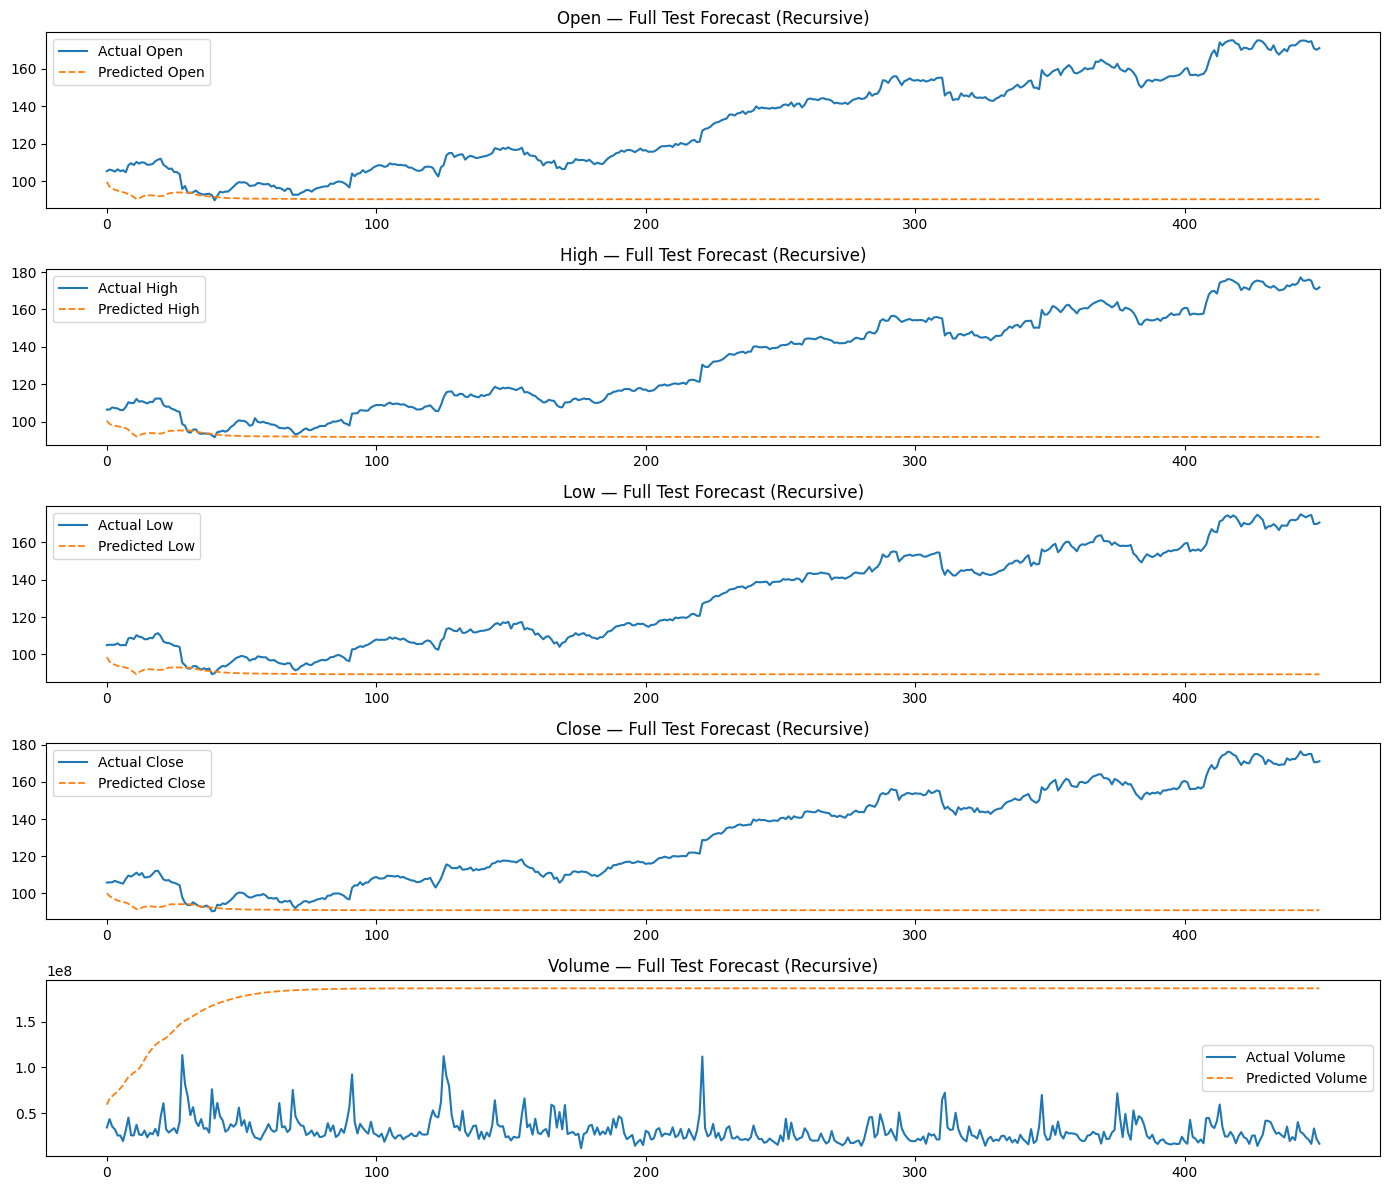

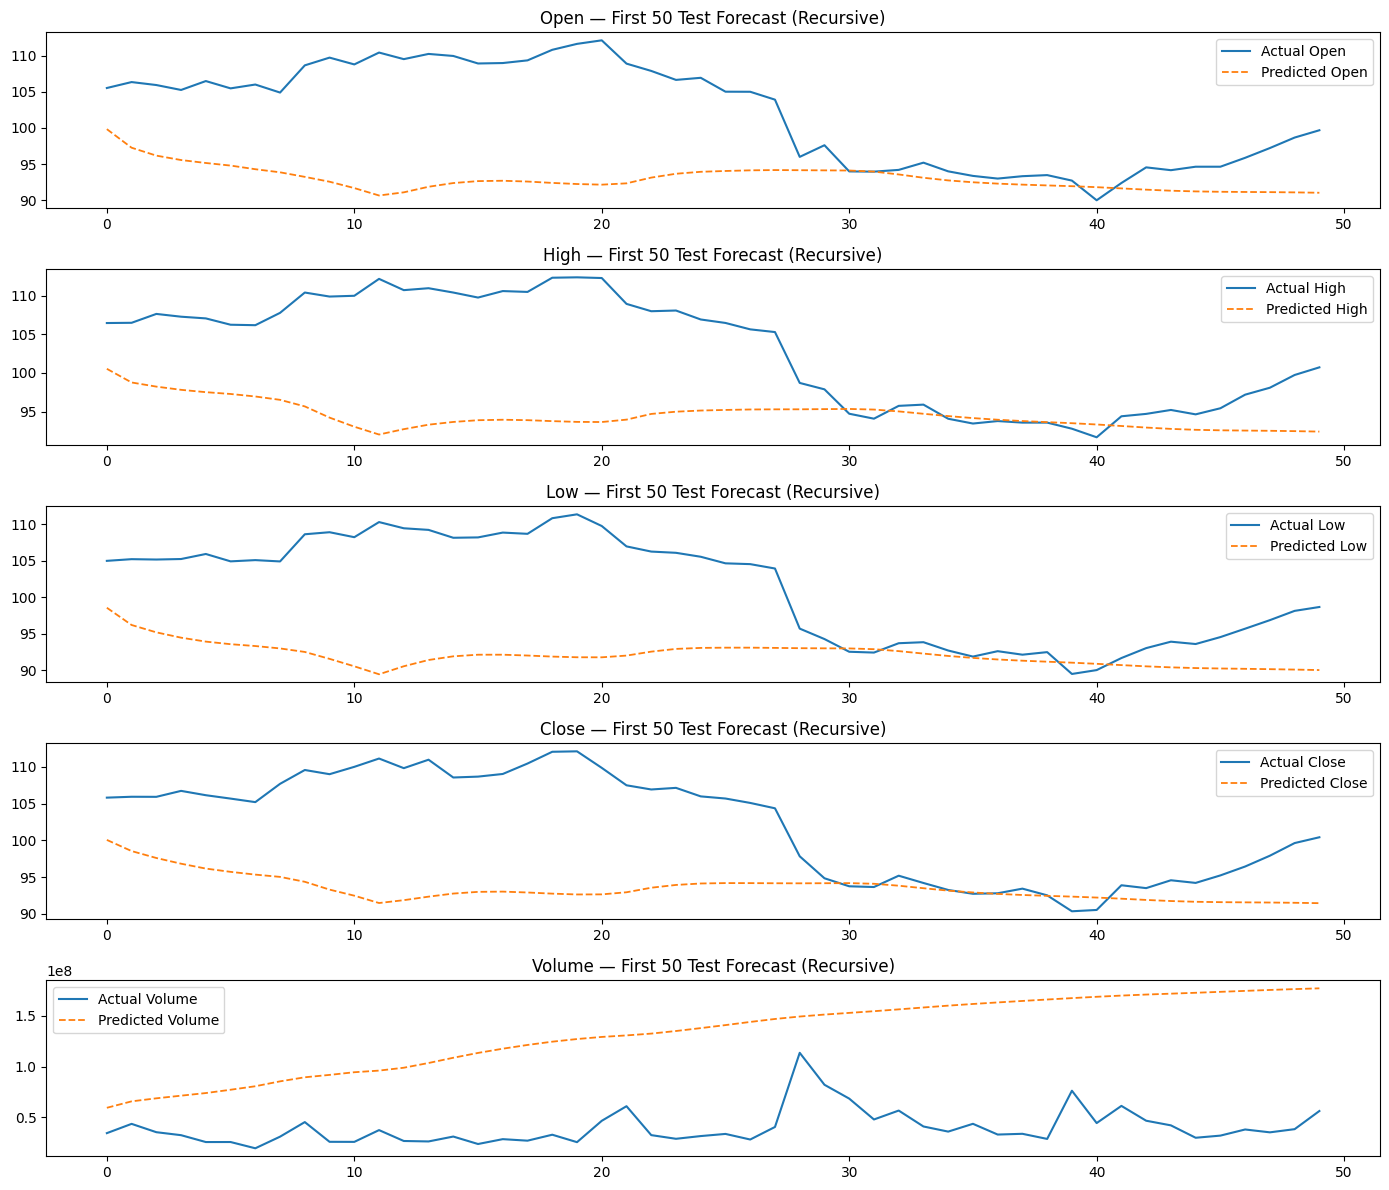

array([2.9278545e+01, 2.9052334e+01, 3.1269077e+01, 2.9210094e+01,
       4.4537640e+07], dtype=float32)

In [ ]:
# fixed final split in raw time
T = len(X)
test_start = int(T * 0.8)
train_end_raw = int(test_start * 0.9)  # train/val split within trainval
val_end_raw = test_start

train_seq, val_seq, (mean, std) = windows_from_raw_with_fold_scaling(
    X, history_size=13, train_end_raw=train_end_raw, val_end_raw=val_end_raw
)

# build test windows with the SAME scaler (fit on train)
X_scaled_full = apply_stats(X, mean, std)
test_seq_full = sequencing(X_scaled_full, history_size=13)
ends = np.arange(test_seq_full.shape[0]) + 13 - 1
test_seq = test_seq_full[ends >= test_start]

trainLoader, valLoader, testLoader = createLoaders(
    train_seq, val_seq, test_seq,
    batchSize=32, responseVariables=list(range(5))
)

model = Transformer(
    num_layers=best_cfg["num_layers"],
    D=best_cfg["D"],
    H=best_cfg["H"],
    hidden_mlp_dim=best_cfg["hidden_mlp_dim"],
    inp_features=5,
    out_features=5,
    dropout_rate=best_cfg["dropout_rate"]
).to(device)

# train using your preferred loop (Adam shown here)
final_val = train_and_validate_fold(model, trainLoader, valLoader, lr=best_cfg["lr"], epochs=20)

# test eval
eval_rollout(model, testDataset, data_mean, data_std)

In [177]:
rmse_per_feature_original(model, testLoader, data_mean, data_std, device)
rmse_f = rmse_per_feature_original(model, testDataset, data_mean, data_std, device)
for n, v in zip(feature_names, rmse_f):
    print(f"{n} last-step RMSE (original units): {v:.4f}")

Open last-step RMSE (original units): 38.4411
High last-step RMSE (original units): 38.1067
Low last-step RMSE (original units): 40.9586
Close last-step RMSE (original units): 38.4233
Volume last-step RMSE (original units): 54104072.0000
